# Developing a solution to predict linear B-cell epitopes in Alphavirus

<b>Hi!</b>
The README file contains more information on the project, its process and data.

<b>Note - </b> It is not always standard practice to add so many comments in a jupyter notebook as I have done, but I have purposely done so to help with better understanding of  the code step by step.

## Analysis

To begin the analysis of the data sets, the needed libraries for use are imported. Over the course of the model development, more libraries were added as needed. Also the random seed number for use (42) was stored for complete reproducibility. Some libraries such as imblearn and xgboost had to be installed before importing as errors were recorded due to the absence of the packages on the jupyter library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
!pip install imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GroupKFold
import sys
!{sys.executable} -m pip install xgboost
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import GroupKFold, cross_val_score


# Set the random seed to a fixed value (e.g. 42)
np.random.seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.8 MB/s eta 0:00:0000:0100:01


# Dataset 1
## Defining some functions which would be called in later cells for returned values
1. Reading the training sets (dataframe)
2. Remove the column having a specific string in its name for the purpose of removing the columns staring with "Info_
3. Using the info_cluster grouping variable to group when splitting the datasets

Reading the dataset csv files presented a Unicode error '(unicode error) 'unicodeescape'' which was fixed by duplicating all backslashes in file path as well as setting 'memory low' to 'False'.

## Exploratory data analysis

Here the focus will be on exploring the data to determine the data types and if there are any null or missing values. From the exploration, we find that all the variables are of the float64 type. To determine any null or missing values, a function was defined to search the columns for null values. No null values were returned when this function was called.


In [4]:
def create_dataframe(data, are_columns = False, column_names = None):
    if are_columns == True:
        return pd.DataFrame(data, columns = column_names)
    return pd.Dataframe(data)
def read_dataframe(dataframe_path):
    return pd.read_csv(dataframe_path, low_memory = False)
def remove_columns_with_name_substring(dataframe, substring):
    return dataframe.loc[:, ~dataframe.columns.str.contains(substring, case=False)]
def get_groups(dataframe, column_name):
    return dataframe[column_name]
df_val = read_dataframe('df_holdout.csv')

In [5]:
df = pd.read_csv('df_training_level1(1).csv', low_memory = False)
df.head()

,Info_PepID,Info_organism_id,Info_protein_id,Info_pos,Info_AA,Info_pubmed_id,Info_epitope_id,Info_host_id,Info_nPos,Info_nNeg,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,CAA51871.1:2,12161,CAA51871.1,685,S,11458006,60725,10000000,2,0,...,0.178513,-0.257270,-0.153925,0.014767,-1.294921,-0.112832,0.260342,0.123651,0.159365,0.172829
1,CAA51871.1:2,12161,CAA51871.1,686,R,11458006,60725,10000000,2,0,...,0.539347,-0.173580,-0.122266,0.235858,-1.230598,-0.060592,0.160817,0.310983,0.146951,0.240393
2,CAA51871.1:2,12161,CAA51871.1,687,L,11458006,60725,10000000,2,0,...,0.224537,-0.165938,-0.125078,0.131652,-1.359426,0.020718,0.160984,0.189219,0.204018,0.336321
3,CAA51871.1:2,12161,CAA51871.1,688,L,11458006,60725,10000000,2,0,...,0.173186,-0.069608,-0.133053,0.043285,-1.559416,-0.032758,0.099643,0.117604,0.112384,0.367813
4,CAA51871.1:2,12161,CAA51871.1,689,E,11458006,60725,10000000,2,0,...,0.136331,-0.068715,0.032138,0.099051,-1.643639,-0.199724,0.076023,-0.128873,0.127291,0.278798


In [6]:
groups = get_groups(df, 'Info_cluster') #to extract the Info_cluster grouping variable

info_prep_id = df_val['Info_PepID']
info_pos = df_val['Info_pos']

df = remove_columns_with_name_substring(df, 'Info') # to remove the columns with names containing "info"
df_val = remove_columns_with_name_substring(df_val, 'Info')

df_columns = df.columns
df.head()

,Class,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,1,-0.161401,0.016928,0.464730,0.071176,-0.166537,-0.101496,0.045268,-0.152964,-0.055976,...,0.178513,-0.257270,-0.153925,0.014767,-1.294921,-0.112832,0.260342,0.123651,0.159365,0.172829
1,1,0.097244,0.187084,0.249089,-0.192334,0.041462,0.040691,-0.047504,0.221144,-0.250569,...,0.539347,-0.173580,-0.122266,0.235858,-1.230598,-0.060592,0.160817,0.310983,0.146951,0.240393
2,1,-0.020377,0.199993,-0.004241,0.068107,0.013872,0.095657,-0.334035,0.215828,-0.230505,...,0.224537,-0.165938,-0.125078,0.131652,-1.359426,0.020718,0.160984,0.189219,0.204018,0.336321
3,1,0.052879,0.149476,-0.008028,0.098507,-0.024391,0.136488,-0.263979,0.180176,-0.376252,...,0.173186,-0.069608,-0.133053,0.043285,-1.559416,-0.032758,0.099643,0.117604,0.112384,0.367813
4,1,-0.009280,-0.023794,-0.070194,0.004226,-0.154706,-0.017921,-0.268468,-0.228312,-0.253118,...,0.136331,-0.068715,0.032138,0.099051,-1.643639,-0.199724,0.076023,-0.128873,0.127291,0.278798


In [7]:
df.info() #to check the feature types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Columns: 1281 entries, Class to feat_esm1b_1279
dtypes: float64(1280), int64(1)
memory usage: 7.3 MB


**All the variables are of the type float64.**

In [8]:
def get_null_info(df): #to get information on any missing or null values in the data
    df = df.copy()
    columns_with_null_values = list()
    columns_and_num_null_values = df.isnull().sum()

    column_names = columns_and_num_null_values.index
    num_null_values = columns_and_num_null_values.values

    for i in range(len(column_names)):
        if num_null_values[i] > 0:
            columns_with_null_values.append((column_names[i], num_null_values[i]))
        else:
            pass
    
    return columns_with_null_values
get_null_info(df)

[]

**There are no null values.**

In [9]:
df.index

RangeIndex(start=0, stop=746, step=1)

In [10]:
def split_features_and_target(dataframe, label):
    dataframe = dataframe.copy()
    y = dataframe[[label]]
    dataframe = dataframe.drop(label, axis = 1)

    return dataframe, y

In [11]:
df, y = split_features_and_target(df, 'Class')

To find the outliers in the data, the Z-score method was employed with a threshold of 3. Using 3 as the cut off value for the limit which is similar to standard deviation methods, hence any any z-score greater than +3 or less than -3 is considered as an outlier. Each column is searched for outliers and the Class data is skipped, z-score is calculated for each data in the columns and identified based on threshold. After running the search for outliers, about 0-7 outliers were sound in each data column.

In [16]:
def get_outliers_info(df):
    z_threshold = 3
    outliers = list()

    # Loop through each feature (column) in the dataset
    for col in df.columns:
        if col != 'Class':  # Skip the target variable
            # Calculate Z-score for each data point in the column
            z_scores = (df[col] - df[col].mean()) / df[col].std()
            # Identify the outliers based on the Z-score threshold
            num_outliers = df[np.abs(z_scores) > z_threshold]
            # Print the number of outliers detected in the column
            outliers.append((col, len(num_outliers)))
    return outliers

get_outliers_info(df)[:5] #to check for outliers in the datatset

[('feat_esm1b_0', 5),
 ('feat_esm1b_1', 2),
 ('feat_esm1b_2', 3),
 ('feat_esm1b_3', 1),
 ('feat_esm1b_4', 2)]

**There are five outliers in the feat_esm1b_0 feature.**

To visualize the variable scales, plots can be created to view the distribution of the data, here the function 'variance' is defined. Here, the Class data is also ignored by starting the visualization range from 1 instead of 0. Also, as the data is large we only plot for some columns instead of all, hence the range stops in 17, visualizing only the first 16 columns. After checking for thevariatio or skewness of the data, the subplots show that there is not much variation in the features.

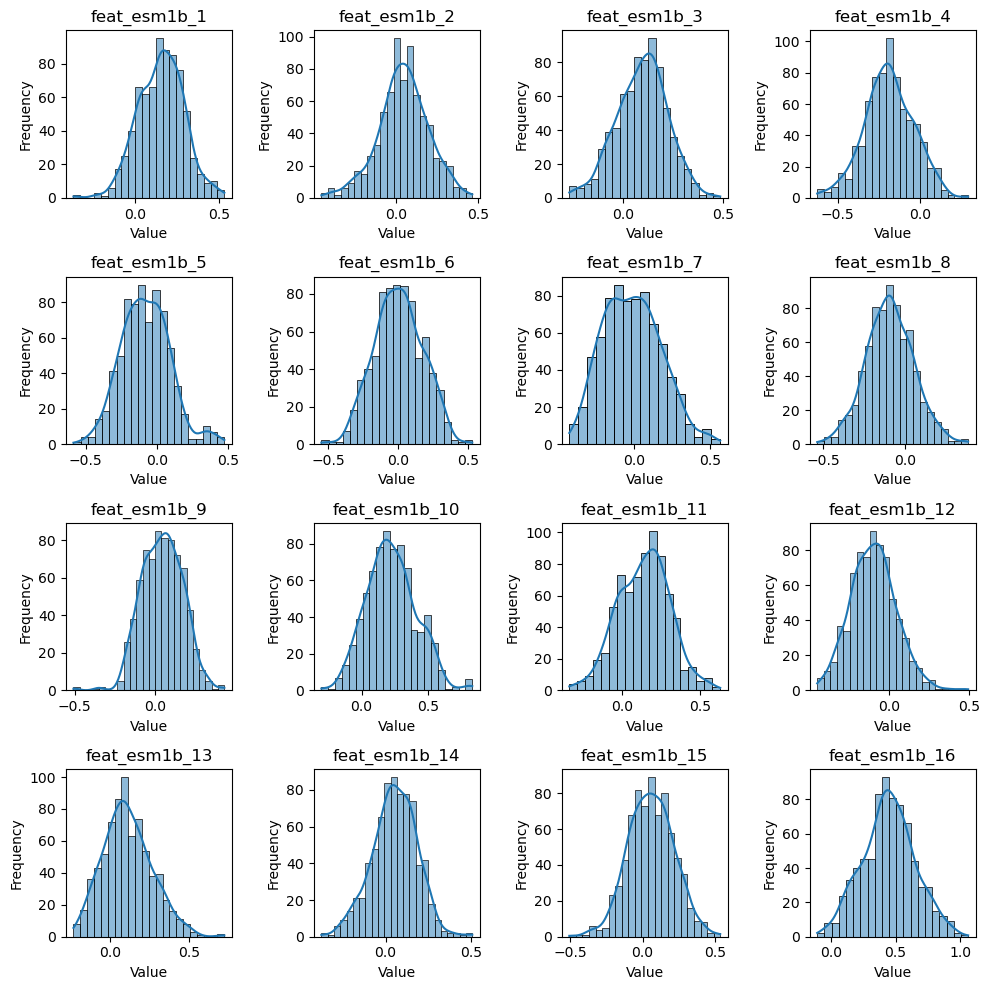

In [18]:
def skewness_info(df, interval):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))#to create subplots of 4 rows by 4 columns
    axes = axes.flatten() #to flatten the axes array
    
      # Loop through the columns of the DataFrame and plot histograms in each subplot
    for i, col in enumerate(df.columns[interval[0]:interval[1]]):
        ax = axes[i]
        sns.histplot(df[col], ax=ax, kde=True)
        ax.set_title(col)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        
          # Remove extra subplots if necessary
    for j in range(len(df.columns[interval[0]:interval[1]]), len(axes)):
        fig.delaxes(axes[j])

    # Adjust spacing between subplots
    fig.tight_layout()

skewness_info(df, [1, 17]) #to visualize only the first 16 data columns

**There is not much skewness present in the features.**

To check if the class is balanced, the class distribution was visualied to show similarities, from the visualization the class is imbalanced. The variables are also checked for categories, from the check if categorical function being called, none of the variables in Dataset 1 are categorical.

In [19]:
def visualize_class_distribution(data_set, label):
    sns.countplot(x=label, data=data_set)
    plt.show()

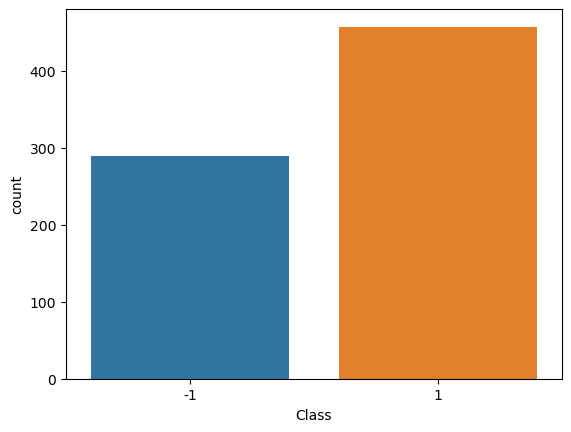

In [20]:
visualize_class_distribution(y, 'Class')

**The class is imbalanced.**

In [21]:
def checking_if_categorical(dataset):
    dataset = dataset.copy()
    # loop through each column in the dataset
    for col in dataset.columns:
        
        # get the number of unique values in the column
        num_unique_values = len(dataset[col].unique())
        
        # calculate the percentage of unique values
        percent_unique = float(num_unique_values) / len(dataset) * 100
        
        # check if the column is categorical or not
        if percent_unique < 10:
            print(col + ' is categorical')
        else:
            print(col + ' is not categorical')

In [22]:
# Checking categorical variables.
checking_if_categorical(df)

feat_esm1b_0 is not categorical
feat_esm1b_1 is not categorical
feat_esm1b_2 is not categorical
feat_esm1b_3 is not categorical
feat_esm1b_4 is not categorical
feat_esm1b_5 is not categorical
feat_esm1b_6 is not categorical
feat_esm1b_7 is not categorical
feat_esm1b_8 is not categorical
feat_esm1b_9 is not categorical
feat_esm1b_10 is not categorical
feat_esm1b_11 is not categorical
feat_esm1b_12 is not categorical
feat_esm1b_13 is not categorical
feat_esm1b_14 is not categorical
feat_esm1b_15 is not categorical
feat_esm1b_16 is not categorical
feat_esm1b_17 is not categorical
feat_esm1b_18 is not categorical
feat_esm1b_19 is not categorical
feat_esm1b_20 is not categorical
feat_esm1b_21 is not categorical
feat_esm1b_22 is not categorical
feat_esm1b_23 is not categorical
feat_esm1b_24 is not categorical
feat_esm1b_25 is not categorical
feat_esm1b_26 is not categorical
feat_esm1b_27 is not categorical
feat_esm1b_28 is not categorical
feat_esm1b_29 is not categorical
feat_esm1b_30 is not

**There are no categorical features.**

## Data Pre-processing
Variable scaling (Normalisation) is carried out by employing the MinMaxScaler function as the data has a bounded range and to ensure the values are within a fixed range and contribute equally to the analysis. The earlier identified outliers which were detemined using z-score areremoved in this phase and the updated shape of our data is presented to be 286 rows and 1280 columns.

In [23]:
def create_dataframe(data, are_columns = False, column_names = None):
    if are_columns == True:
        return pd.Dataframe(data, columns = column_names)
    return pd.Dataframe(data)

In [24]:
# Variable scaling (e.g., normalization)

scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns = df_columns[1:])

In [25]:
df.head()

,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,feat_esm1b_9,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,0.428515,0.427146,1.000000,0.452312,0.499109,0.456712,0.551187,0.276374,0.522243,0.675514,...,0.539212,0.217506,0.366829,0.358090,0.186152,0.340606,0.592088,0.725194,0.607687,0.525090
1,0.677822,0.615808,0.765210,0.102992,0.726487,0.590382,0.464833,0.651483,0.311073,0.400067,...,0.990771,0.325381,0.407648,0.610937,0.212490,0.402046,0.494638,0.959491,0.594229,0.596083
2,0.564448,0.630120,0.489385,0.448243,0.696327,0.642054,0.198127,0.646152,0.332846,0.528802,...,0.596808,0.335233,0.404022,0.491764,0.159739,0.497676,0.494801,0.807200,0.656091,0.696882
3,0.635059,0.574110,0.485262,0.488542,0.654499,0.680439,0.263336,0.610405,0.174685,0.530657,...,0.532546,0.459400,0.393741,0.390705,0.077851,0.434783,0.434740,0.717630,0.556758,0.729972
4,0.575144,0.381995,0.417576,0.363560,0.512042,0.535281,0.259157,0.200825,0.308306,0.602491,...,0.486425,0.460552,0.606726,0.454481,0.043364,0.238413,0.411613,0.409360,0.572917,0.636438


In [26]:
def remove_outliers(dataset, label, groups, threshold = 3): #creating function to remove outliers
    dataset = dataset.copy()
    label = label.copy()
    groups = groups.copy()

    z_scores = zscore(dataset)
    dataset = dataset[(z_scores < threshold).all(axis=1)]

    label = label.iloc[dataset.index]
    groups = groups.iloc[dataset.index]

    return dataset, label, groups

In [27]:
# Treating of outliers. Using z-score to remove the outliers.
df, y, groups = remove_outliers(df, y, groups, threshold = 3) #calling function to remove the outliers.

In [28]:
print(f"Shape of the dataset after removing outliers: {df.shape}") #updated dataset shape

Shape of the dataset after removing outliers: (286, 1280)


## Feature reduction
For feature reduction PCA method has been employed. The values 10 to 50, 50 to 100 as the number of components were tested and 100 as the number of the components seemed to perform best.

In [29]:
def perform_PCA(dataframe, label, validation_dataframe, n_components = 100): #creating function to perform PCA
    dataframe = dataframe.copy()

    pca = PCA(n_components=n_components, random_state = 42)
    dataframe = pca.fit_transform(dataframe, label)
    validation_dataframe = pca.transform(validation_dataframe)

    dataframe = pd.DataFrame(dataframe)
    validation_dataframe = pd.DataFrame(validation_dataframe)

    return dataframe, validation_dataframe

In [30]:
# Perform PCA for feature extraction
df, df_val = perform_PCA(df, y, df_val, n_components = 100) #calling function to perform PCA for feature extraction

## Data rebalancing - Oversampling
As earlier discussed, the data needs to be rebalanced. From this information, the decision to balance the class is made and from research using oversampling whcih helps to improve the bias to the minority class. The SMOTE() function is used to carry out this oversampling. Once oversampling is carried out, the shape of the data is checked once more. The class is also visualized to view the balance, and the class is confirmed to be balanced.

In [31]:
groups = pd.DataFrame(groups)
groups = groups.reset_index(drop=True)

In [32]:
# concatenating the groups before oversampling
df = pd.concat([df, groups], axis = 1)
# converting data type of column names from int to string
df.columns = df.columns.astype(str) 

In [33]:
def perform_over_sampling(X, y):
    smote = SMOTE(random_state = 42)
    X, y = smote.fit_resample(X, y) #applying smote

    return X, y

In [34]:
# perform oversampling
df, y = perform_over_sampling(df, y) #calling function to perform oversampling

In [35]:
print(f"Shape of the dataset after oversampling: {df.shape}")

Shape of the dataset after oversampling: (336, 101)


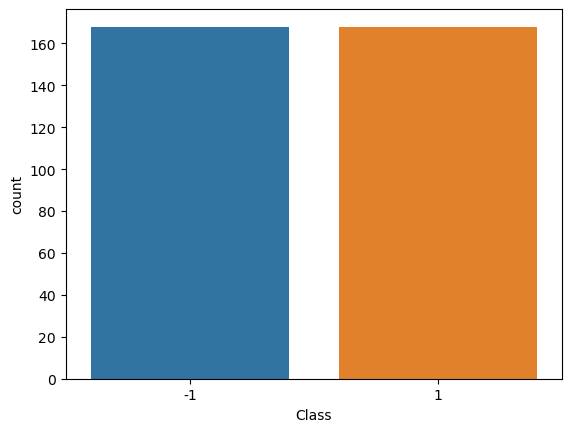

In [36]:
visualize_class_distribution(y, 'Class') #checking the class imbalance after oversampling

In [37]:
groups = df['Info_cluster']
df = df.drop('Info_cluster', axis = True)

df, y, groups = shuffle(df, y, groups, random_state=42)
df = df.reset_index(drop=True)
y = y.reset_index(drop=True)
groups = groups.reset_index(drop=True)

y[y < 0] = 0

## Modelling

In the modelling, 2 models have been employed, the first being Random_forest and the second being XGBoost, the Random_Forest is the base model and XG_Boost is the additional model. 

Firstly the models are defined for use and then stored afterwhich they are run and their performance are measured.

In [38]:
# from sklearn.utils import shuffle
X_train = df.copy()
y_train = y.copy()

X_train, y_train, groups = shuffle(X_train, y_train, groups.copy(), random_state=42)

In [39]:
# Define the models
models = {
    "Random_Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

# Dictionary to store best models
cv = GroupKFold(n_splits=4)

models_score = {} 

# Iterate over the models and measure their performance
for name, model in models.items(): 
    models_score[name] = cross_val_score(model, df, y.values.ravel(), cv=cv, groups=groups, scoring='roc_auc')

    print(f'Model Name: {name}')
    print(f'Mean AUC: {np.mean(models_score[name]):.5f}')
    print('-'*50)

Model Name: Random_Forest
Mean AUC: 0.79311
--------------------------------------------------
Model Name: XGBoost
Mean AUC: 0.83152
--------------------------------------------------



The model performance is as follows

Model Name: Random_Forest. 
Mean AUC: 0.79311

Model Name: XGBoost
Mean AUC: 0.83152

From the run, the XGBoost performs better 

Hyperparameter tuning is carried out to ensure the models give their maximum accuracy. The parameters used performed best out of all values tested.

## **HYPER-PARAMETER TUNING**

In [40]:
#Defining the the parameter grids for the models

# Define the parameter grid for Random Forest
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 15],
    "min_samples_leaf": [1, 2, 4],
}

# Define the parameter grid for XGBoost
xgb_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.1, 0.01, 0.001],
    "max_depth": [5, 10, 15],
    "colsample_bytree": [0.5, 0.7, 0.9],
}

# Create a dictionary of models with hyperparameter tuning
models = {
    "Random_Forest": RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_grid),
    "XGBoost": RandomizedSearchCV(XGBClassifier(random_state=42), xgb_param_grid),
}

In [41]:
cv = GroupKFold(n_splits=4)

# Dictionary to store best models
models_score = {}

# Iterate over the models and measure their performance
for name, model in models.items():
    models_score[name] = cross_val_score(model, df, y.values.ravel(), cv=cv, groups=groups, scoring='roc_auc')

    print(f'Model Name: {name}')
    print(f'Mean AUC: {np.mean(models_score[name]):.5f}')
    print('-'*50)

y[y == 0] = -1

Model Name: Random_Forest
Mean AUC: 0.81144
--------------------------------------------------
Model Name: XGBoost
Mean AUC: 0.81193
--------------------------------------------------


## Results

After hyperparameter tuning is carried out the results are as follows 

Model Name: Random_Forest
#### Mean AUC: 0.81144
--------------------------------------------------
Model Name: XGBoost
#### Mean AUC: 0.81193
--------------------------------------------------

# Analaysis of Dataset 2 

In [42]:
# Read the dataset
def read_dataset(dataset_path):
    return pd.read_csv(dataset_path, low_memory = False)
def remove_columns_with_name_substring(dataset, substring):
    return dataset.loc[:, ~dataset.columns.str.contains(substring, case=False)]
def get_groups(dataset, column_name):
    return dataset[column_name]
df_val = read_dataset('df_holdout.csv')

In [43]:
df = pd.read_csv('df_training_level2(1).csv', low_memory = False)
df.head()

,Info_PepID,Info_organism_id,Info_protein_id,Info_pos,Info_AA,Info_pubmed_id,Info_epitope_id,Info_host_id,Info_nPos,Info_nNeg,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,BAA01867.1:2,1678143,BAA01867.1,262,E,10449466,14543,9606,1,1,...,-0.070886,-0.017200,-0.117530,-0.007250,-1.071874,-0.519040,-0.308719,-0.281276,-0.256712,0.405690
1,BAA01867.1:2,1678143,BAA01867.1,263,T,10449466,14543,9606,1,1,...,0.220630,-0.210780,-0.021335,0.323588,-0.736865,-0.343829,-0.507386,-0.020137,-0.166644,0.751316
2,BAA01867.1:2,1678143,BAA01867.1,264,S,10449466,14543,9606,1,1,...,0.107350,-0.059491,-0.167905,0.257423,-0.930690,-0.271957,-0.133815,0.044392,-0.299376,0.461547
3,BAA01867.1:2,1678143,BAA01867.1,265,G,10449466,14543,9606,1,1,...,0.253621,-0.267090,-0.109026,0.091992,-0.813677,-0.187964,-0.142268,0.091157,-0.436975,0.369129
4,BAA01867.1:2,1678143,BAA01867.1,266,V,10449466,14543,9606,1,1,...,0.027382,0.018629,-0.157104,0.305302,-1.121274,-0.048636,-0.246171,0.147852,-0.299121,0.225209


In [44]:
# Extract the grouping variable
groups = get_groups(df, 'Info_cluster')

# Get these features for prediction dataset
info_prep_id = df_val['Info_PepID']
info_pos = df_val['Info_pos']

# Remove columns with names containing "info"
df = remove_columns_with_name_substring(df, 'Info')
df_val = remove_columns_with_name_substring(df_val, 'Info')

df_columns = df.columns
df.head()

,Class,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,-1,-0.021067,-0.165189,0.173732,0.104066,-0.100211,-0.042768,-0.430647,-0.212912,-0.632184,...,-0.070886,-0.017200,-0.117530,-0.007250,-1.071874,-0.519040,-0.308719,-0.281276,-0.256712,0.405690
1,-1,0.026400,0.028715,0.093638,-0.046767,0.072711,-0.321925,-0.314515,0.071320,-0.413840,...,0.220630,-0.210780,-0.021335,0.323588,-0.736865,-0.343829,-0.507386,-0.020137,-0.166644,0.751316
2,-1,-0.140944,0.106401,0.205669,0.160118,-0.104789,-0.309539,-0.205587,0.058554,-0.466790,...,0.107350,-0.059491,-0.167905,0.257423,-0.930690,-0.271957,-0.133815,0.044392,-0.299376,0.461547
3,-1,0.120088,0.108923,-0.086904,0.196164,-0.251497,-0.205923,-0.483595,0.061114,-0.623314,...,0.253621,-0.267090,-0.109026,0.091992,-0.813677,-0.187964,-0.142268,0.091157,-0.436975,0.369129
4,-1,0.083401,0.060489,0.070889,-0.058935,-0.192792,-0.258103,-0.379416,0.123201,-0.570444,...,0.027382,0.018629,-0.157104,0.305302,-1.121274,-0.048636,-0.246171,0.147852,-0.299121,0.225209


## Exploratory data analysis

Here the focus will be on exploring the data to determine the data types and if there are any null or missing values. From the exploration, we find that all the variables are of the float64 type. To determine any null or missing values, a function was defined to search the columns for null values. There are approximately 521 null values in all the features. the values can not be substituted as a whole row contains null values. the null values are removed.


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946 entries, 0 to 4945
Columns: 1281 entries, Class to feat_esm1b_1279
dtypes: float64(1280), int64(1)
memory usage: 48.3 MB


In [46]:
def get_null_info(df): #to get information on any missing or null values in the data
    df = df.copy()
    columns_with_null_values = list()
    columns_and_num_null_values = df.isnull().sum()

    column_names = columns_and_num_null_values.index
    num_null_values = columns_and_num_null_values.values

    for i in range(len(column_names)):
        if num_null_values[i] > 0:
            columns_with_null_values.append((column_names[i], num_null_values[i]))
        else:
            pass
    
    return columns_with_null_values
get_null_info(df)

[('feat_esm1b_0', 521),
 ('feat_esm1b_1', 521),
 ('feat_esm1b_2', 521),
 ('feat_esm1b_3', 521),
 ('feat_esm1b_4', 521),
 ('feat_esm1b_5', 521),
 ('feat_esm1b_6', 521),
 ('feat_esm1b_7', 521),
 ('feat_esm1b_8', 521),
 ('feat_esm1b_9', 521),
 ('feat_esm1b_10', 521),
 ('feat_esm1b_11', 521),
 ('feat_esm1b_12', 521),
 ('feat_esm1b_13', 521),
 ('feat_esm1b_14', 521),
 ('feat_esm1b_15', 521),
 ('feat_esm1b_16', 521),
 ('feat_esm1b_17', 521),
 ('feat_esm1b_18', 521),
 ('feat_esm1b_19', 521),
 ('feat_esm1b_20', 521),
 ('feat_esm1b_21', 521),
 ('feat_esm1b_22', 521),
 ('feat_esm1b_23', 521),
 ('feat_esm1b_24', 521),
 ('feat_esm1b_25', 521),
 ('feat_esm1b_26', 521),
 ('feat_esm1b_27', 521),
 ('feat_esm1b_28', 521),
 ('feat_esm1b_29', 521),
 ('feat_esm1b_30', 521),
 ('feat_esm1b_31', 521),
 ('feat_esm1b_32', 521),
 ('feat_esm1b_33', 521),
 ('feat_esm1b_34', 521),
 ('feat_esm1b_35', 521),
 ('feat_esm1b_36', 521),
 ('feat_esm1b_37', 521),
 ('feat_esm1b_38', 521),
 ('feat_esm1b_39', 521),
 ('feat_es

**There are approximately 521 null values in all the features. We cannot substitute them with other values because the whole row contain the null values.**

In [47]:
# if there are null values then remove them
df = df.dropna()
df, y = split_features_and_target(df, 'Class')

In [48]:
get_null_info(df)

[]

To find the outliers in the data, the Z-score method was employed with a threshold of 3. Using 3 as the cut off value for the limit which is similar to standard deviation methods, hence any any z-score greater than +3 or less than -3 is considered as an outlier. Each column is searched for outliers and the Class data is skipped, z-score is calculated for each data in the columns and identified based on threshold. After running the search for outliers, a significatly larger number of outliers than in the first dataset were found up.

To visualize the variable scales, plots can be created to view the distribution of the data, here the function 'variance' is defined. Here, the Class data is also ignored by starting the visualization range from 1 instead of 0. Also, as the data is large we only plot for some columns instead of all, hence the range stops in 17, visualizing only the first 16 columns. After checking for thevariatio or skewness of the data, the subplots show that there is not much variation in the features.

In [49]:
def get_outliers_info(df):
    z_threshold = 3
    outliers = list()
    for col in df.columns:
        if col != 'Class':  #skipping the target variable
            z_scores = (df[col] - df[col].mean()) / df[col].std() #to calculate Z-score for each data point in the column and indentify outliers based on set threshold
            num_outliers = df[np.abs(z_scores) > z_threshold]
            outliers.append((col, len(num_outliers)))
    return outliers
get_outliers_info(df) #to check for outliers in the datatset

[('feat_esm1b_0', 38),
 ('feat_esm1b_1', 62),
 ('feat_esm1b_2', 32),
 ('feat_esm1b_3', 45),
 ('feat_esm1b_4', 23),
 ('feat_esm1b_5', 30),
 ('feat_esm1b_6', 16),
 ('feat_esm1b_7', 21),
 ('feat_esm1b_8', 40),
 ('feat_esm1b_9', 31),
 ('feat_esm1b_10', 42),
 ('feat_esm1b_11', 36),
 ('feat_esm1b_12', 33),
 ('feat_esm1b_13', 44),
 ('feat_esm1b_14', 21),
 ('feat_esm1b_15', 38),
 ('feat_esm1b_16', 27),
 ('feat_esm1b_17', 42),
 ('feat_esm1b_18', 45),
 ('feat_esm1b_19', 32),
 ('feat_esm1b_20', 34),
 ('feat_esm1b_21', 38),
 ('feat_esm1b_22', 25),
 ('feat_esm1b_23', 17),
 ('feat_esm1b_24', 14),
 ('feat_esm1b_25', 34),
 ('feat_esm1b_26', 31),
 ('feat_esm1b_27', 42),
 ('feat_esm1b_28', 51),
 ('feat_esm1b_29', 39),
 ('feat_esm1b_30', 13),
 ('feat_esm1b_31', 27),
 ('feat_esm1b_32', 26),
 ('feat_esm1b_33', 27),
 ('feat_esm1b_34', 29),
 ('feat_esm1b_35', 51),
 ('feat_esm1b_36', 46),
 ('feat_esm1b_37', 21),
 ('feat_esm1b_38', 49),
 ('feat_esm1b_39', 18),
 ('feat_esm1b_40', 48),
 ('feat_esm1b_41', 26),
 (

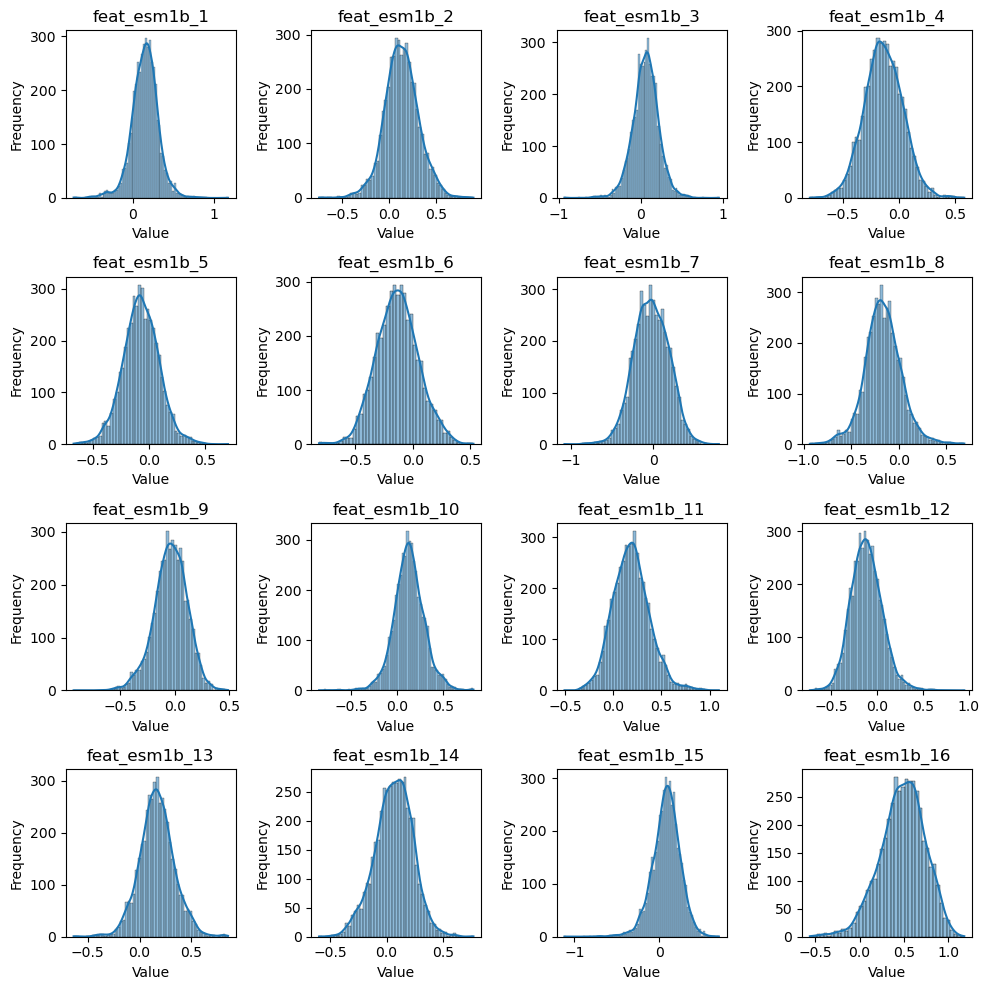

In [50]:
def variance_info(df, interval):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))#to create subplots of 4 rows by 4 columns
    axes = axes.flatten() #to flatten the axes array
    for i, col in enumerate(df.columns[interval[0]:interval[1]]):
        ax = axes[i]
        sns.histplot(df[col], ax=ax, kde=True)
        ax.set_title(col)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        
         # Remove extra subplots if necessary
    for j in range(len(df.columns[interval[0]:interval[1]]), len(axes)):
        fig.delaxes(axes[j])

    # Adjust spacing between subplots
    fig.tight_layout()

variance_info(df, [1, 17]) #to visualize only the first 16 data columns

**All the features mentioned above have bell-shaped distribution.**

To check if the class is balanced, the class distribution was visualied to show similarities, from the visualization the class is imbalanced. The variables are also checked for categories, from the check if categorical function being called, none of the variables in Dataset 2 are categorical.

In [51]:
def visualize_class_distribution(data_set, label):
    sns.countplot(x=label, data=data_set)
    plt.show()

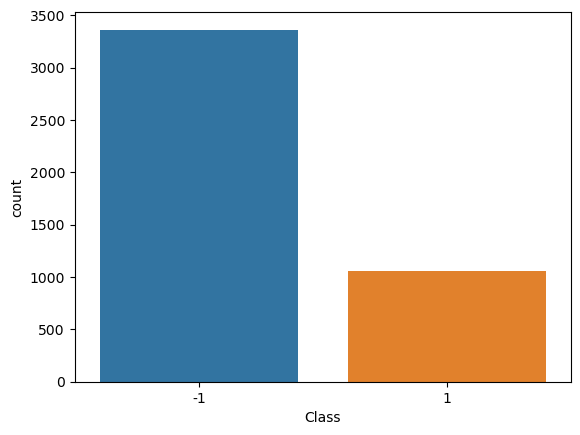

In [52]:
visualize_class_distribution(y, 'Class') 

**The class is imbalanced.**

In [53]:
def checking_if_categorical(dataset):
    dataset = dataset.copy()
    # loop through each column in the dataset
    for col in dataset.columns:
        
        # get the number of unique values in the column
        num_unique_values = len(dataset[col].unique())
        
        # calculate the percentage of unique values
        percent_unique = float(num_unique_values) / len(dataset) * 100
        
        # check if the column is categorical or not
        if percent_unique < 10:
            print(col + ' is categorical')
        else:
            print(col + ' is not categorical')

In [54]:
# Checking categorical variables.
checking_if_categorical(df)

feat_esm1b_0 is not categorical
feat_esm1b_1 is not categorical
feat_esm1b_2 is not categorical
feat_esm1b_3 is not categorical
feat_esm1b_4 is not categorical
feat_esm1b_5 is not categorical
feat_esm1b_6 is not categorical
feat_esm1b_7 is not categorical
feat_esm1b_8 is not categorical
feat_esm1b_9 is not categorical
feat_esm1b_10 is not categorical
feat_esm1b_11 is not categorical
feat_esm1b_12 is not categorical
feat_esm1b_13 is not categorical
feat_esm1b_14 is not categorical
feat_esm1b_15 is not categorical
feat_esm1b_16 is not categorical
feat_esm1b_17 is not categorical
feat_esm1b_18 is not categorical
feat_esm1b_19 is not categorical
feat_esm1b_20 is not categorical
feat_esm1b_21 is not categorical
feat_esm1b_22 is not categorical
feat_esm1b_23 is not categorical
feat_esm1b_24 is not categorical
feat_esm1b_25 is not categorical
feat_esm1b_26 is not categorical
feat_esm1b_27 is not categorical
feat_esm1b_28 is not categorical
feat_esm1b_29 is not categorical
feat_esm1b_30 is not

**There are no categorical features**

## Data pre-processing
Variable scaling (Normalisation) is carried out by employing the MinMaxScaler function as the data has a bounded range and to ensure the values are within a fixed range and contribute equally to the analysis. The earlier identified outliers which were detemined using z-score areremoved in this phase and the updated shape of our data is presented to be 2448 rows and 1280 columns.

In [55]:
scaler = MinMaxScaler() #Variable scalning (Normalisation)
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns = df_columns[1:])

In [56]:
df.head()

,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,feat_esm1b_9,...,feat_esm1b_1270,feat_esm1b_1271,feat_esm1b_1272,feat_esm1b_1273,feat_esm1b_1274,feat_esm1b_1275,feat_esm1b_1276,feat_esm1b_1277,feat_esm1b_1278,feat_esm1b_1279
0,0.529280,0.296818,0.559672,0.551174,0.502866,0.458077,0.287507,0.460983,0.185874,0.711058,...,0.230540,0.526310,0.489996,0.482211,0.225887,0.134131,0.285128,0.341869,0.479975,0.716709
1,0.559063,0.398974,0.510941,0.470936,0.628606,0.254337,0.373870,0.611671,0.320352,0.883073,...,0.368509,0.386134,0.559824,0.680917,0.324142,0.250568,0.150128,0.548591,0.532182,0.894864
2,0.454063,0.439902,0.579103,0.580991,0.499538,0.263377,0.454875,0.604903,0.287740,0.760295,...,0.314896,0.495686,0.453429,0.641177,0.267295,0.298330,0.403980,0.599674,0.455245,0.745501
3,0.617848,0.441231,0.401096,0.600166,0.392859,0.339000,0.248132,0.606260,0.191337,0.873815,...,0.384124,0.345359,0.496170,0.541817,0.301614,0.354147,0.398236,0.636694,0.375486,0.697863
4,0.594829,0.415714,0.497100,0.464463,0.435546,0.300917,0.325606,0.639176,0.223900,0.812121,...,0.277048,0.552255,0.461270,0.669934,0.211398,0.446737,0.327631,0.681576,0.455392,0.623679


In [57]:
def remove_outliers(dataset, label, groups, threshold = 3):
    dataset = dataset.copy()
    label = label.copy()
    groups = groups.copy()

    z_scores = zscore(dataset)
    dataset = dataset[(z_scores < threshold).all(axis=1)]

    label = label.iloc[dataset.index]
    groups = groups.iloc[dataset.index]

    return dataset, label, groups

In [58]:
df, y, groups = remove_outliers(df, y, groups, threshold = 3)
print(f"Shape of the dataset after removing outliers: {df.shape}")

Shape of the dataset after removing outliers: (2448, 1280)


## Feature Exctraction
For feature reduction PCA method has been employed. The values 10 to 50, 50 to 100 as the number of components were tested and 100 as the number of the components seemed to perform best.

In [59]:
#calling function to perform PCA for feature extraction
df, df_val = perform_PCA(df, y, df_val, n_components = 100) 

## Data rebalancing - Oversampling
As earlier discussed, the data needs to be rebalanced. From this information, the decision to balance the class is made and from research using oversampling whcih helps to improve the bias to the minority class. The SMOTE() function is used to carry out this oversampling. Once oversampling is carried out, the shape of the data is checked once more. The class is also visualized to view the balance, and the class is confirmed to be balanced.

In [60]:
groups = pd.DataFrame(groups)
groups = groups.reset_index(drop=True)

In [61]:
# concatenating the groups before oversampling
df = pd.concat([df, groups], axis = 1)
# converting data type of column names from int to string
df.columns = df.columns.astype(str)

In [62]:
# perform oversampling
df, y = perform_over_sampling(df, y)
print(f"Shape of the dataset after oversampling: {df.shape}")

Shape of the dataset after oversampling: (3520, 101)


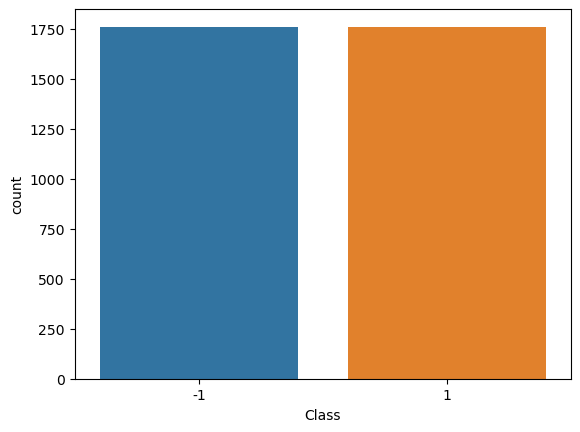

In [63]:
visualize_class_distribution(y, 'Class')

**Class is now balanced**

In [64]:
groups = df['Info_cluster']
df = df.drop('Info_cluster', axis = True)

df, y, groups = shuffle(df, y, groups, random_state=42)
df = df.reset_index(drop=True)
y = y.reset_index(drop=True)
groups = groups.reset_index(drop=True)
y[y < 0] = 0

In [65]:
# from sklearn.utils import shuffle
X_train = df.copy()
y_train = y.copy()

X_train, y_train, groups = shuffle(X_train, y_train, groups.copy(), random_state=42)

## Modelling
In the modelling, 2 models have been employed, the first being Random_forest and the second being XGBoost, the Random_Forest is the base model and XG_Boost is the additional model. 

Firstly the models are defined for use and then stored afterwhich they are run and their performance are measured.

In [66]:
# Define the models
models = {
    "Random_Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

cv = GroupKFold(n_splits=4)
# Dictionary to store best models
models_score = {}

# Iterate over the models and measure their performance
for name, model in models.items():
    models_score[name] = cross_val_score(model, df, y.values.ravel(), cv=cv, groups=groups, scoring='roc_auc')

    print(f'Model Name: {name}')
    print(f'Mean AUC: {np.mean(models_score[name]):.5f}')
    print('-'*50)


Model Name: Random_Forest
Mean AUC: 0.96336
--------------------------------------------------
Model Name: XGBoost
Mean AUC: 0.97179
--------------------------------------------------




The model performance is as follows

Model Name: Random_Forest. 
Mean AUC: 0.96336

Model Name: XGBoost
Mean AUC: 0.97179

From the run, the XGBoost performs better 

Hyperparameter tuning is carried out to ensure the models give their maximum accuracy. The parameters used performed best out of all values tested.

## **HYPER-PARAMETER TUNING**

In [67]:
# Define the parameter grid for Random Forest
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, 15],
    "min_samples_leaf": [1, 2, 4],
}

# Define the parameter grid for XGBoost
xgb_param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.1, 0.01, 0.001],
    "max_depth": [5, 10, 15],
    "colsample_bytree": [0.5, 0.7, 0.9],
}

# Create a dictionary of models with hyperparameter tuning
models = {
    "Random_Forest": RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param_grid),
    "XGBoost": RandomizedSearchCV(XGBClassifier(random_state=42), xgb_param_grid),
}

In [68]:
cv = GroupKFold(n_splits=4)

# Dictionary to store best models
models_score = {}

# Iterate over the models and measure their performance
for name, model in models.items():
    models_score[name] = cross_val_score(model, df, y.values.ravel(), cv=cv, groups=groups, scoring='roc_auc')

    print(f'Model Name: {name}')
    print(f'Mean AUC: {np.mean(models_score[name]):.5f}')
    print('-'*50)

y[y == 0] = -1

Model Name: Random_Forest
Mean AUC: 0.96240
--------------------------------------------------
Model Name: XGBoost
Mean AUC: 0.97075
--------------------------------------------------


## Results

Model Name: Random_Forest
#### Mean AUC: 0.96240
--------------------------------------------------
Model Name: XGBoost
#### Mean AUC: 0.97075
--------------------------------------------------

In [69]:
y[y < 0] = 0
xgboost_classifier_ = XGBClassifier(random_state=42)
xgboost_classifier_.fit(df, y)
y_pred = xgboost_classifier_.predict(df_val)

In [70]:
y_pred = pd.DataFrame(y_pred, columns = ['Prediction']) #to get the prediction file
y_pred[y_pred == 0] = -1
pd.concat([info_prep_id, info_pos, y_pred], axis = 1).to_csv('model_predictions.csv', index = False)

## Conclusion
For the first dataset, the results show that the Random Forest model have improved in terms of Mean AUC after hyperparameter tuning and XGBoost models have sligtly reduced in terms of Mean AUC after hyperparameter tuning. For the Random Forest model, the Mean AUC has increased from 0.79311 before hyperparameter tuning to 0.81144 after hyperparameter tuning. As for the XGBoost model, the Mean AUC has reduced from 0.83152 before hyperparameter tuning to 0.81193 after hyperparameter tuning. These improvements suggest that hyperparameter tuning has positively impacted the performance of the Random Forest models, resulting in higher Mean AUC values but negatively imapcted the XGBoost model resulting in slightly lower MEan AUC values. It is worth noting that the Random Forest model was used as the base model in this study.

For the second dataset, the hyperparameter tuning process has resulted in a slightly lower mean AUC for both the Random Forest and XGBoost models, from 0.96336 to 0.96240 for the Random Forest, while the mean AUC for the XGBoost model slightly reduced from 0.97179 to 0.97075. This suggests that the hyperparameter tuning process may have had a slightly negative impact on the performance of both models.
After analysing all the results, it can be concluded that the XGBoost model is the best model for this particular solution due to its higher Mean AUC values over the Random Forest model.


## References

1. Using z-score to find outliers https://www.analyticsvidhya.com/blog/2022/08/dealing-with-outliers-using-the-z-score-method/
2. Outlier Detection (Part 1) - IQR, Standard Deviation, Z-score and Modified Z-score https://towardsdatascience.com/outlier-detection-part1-821d714524c#:~:text=Usually%20z%2Dscore%20%3D3%20is,similar%20to%20standard%20deviation%20method.
3. Creating multiple subplots using plt.subplots https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
4. Subplots Tips and Tricks https://napsterinblue.github.io/notes/python/viz/subplots/
5. How to use SMOTE for imbalanced classification https://practicaldatascience.co.uk/machine-learning/how-to-use-smote-for-imbalanced-classification
6. Balancing your Target Feature with SMOTE() Function https://rodrigodutcosky.medium.com/balancing-your-target-feature-with-smote-function-b41404503d9c
7. Oversampling and Undersampling - A technique for Imbalanced Classification https://towardsdatascience.com/oversampling-and-undersampling-5e2bbaf56dcf#:~:text=The%20concept%20is%20that%20we,on%20the%20majority%20class%20examples.
8. MinMaxScaler vs StandardScaler – Python Examples https://vitalflux.com/minmaxscaler-standardscaler-python-examples/?utm_content=cmp-true
9. Mastering XGBoost Parameter Tuning: A Complete Guide with Python Codes  https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
10. Why Hyper parameter tuning is important for your model ? https://medium.com/analytics-vidhya/why-hyper-parameter-tuning-is-important-for-your-model-1ff4c8f145d3
11. Feature extraction https://scikit-learn.org/stable/modules/feature_extraction.html